In [332]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math

### Load model

In [333]:
undamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/undamped_k12"
undamped_name = "model_undamped_k12.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [334]:
N = 5120
t_span = (0, 15)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [335]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [336]:
w_list_transfer = [1]
zeta_list = [0.0]
forcing_list = [forcing.zeroes_2D(numpy=True)]
ic_list = [[1, 0]]
epsilon_list = [0.8]
p_list = [12]
q = 3

In [337]:
ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta_list[0], forcing_1D=lambda t: np.zeros_like(t), q=q, epsilon=epsilon_list[0])
numerical_undamped_duffing = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0])

## Standard Perturbation

In [338]:
NN_TL_solution_standard, perturbation_solution_standard, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution_standard = NN_TL_solution_standard.squeeze()

In [339]:
PINN_x_solution_standard = [perturbation_solution_standard[i][:, 0] for i in range(len(perturbation_solution_standard))]
PINN_x_solution_series_standard = standard.calculate_general_series(PINN_x_solution_standard, epsilon=epsilon_list[0])

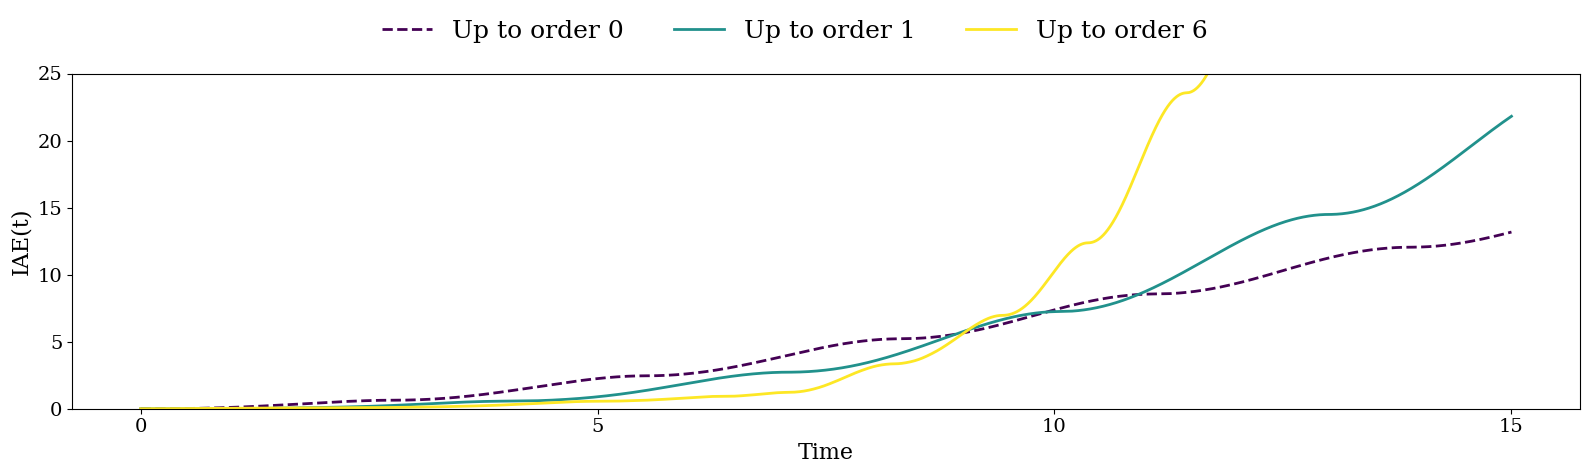

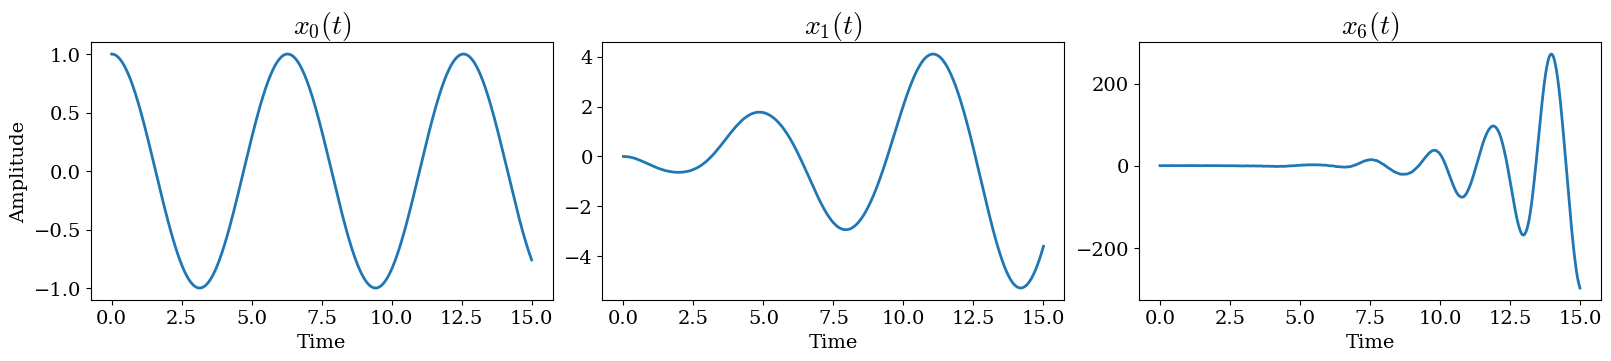

In [340]:
standard.plot_IAE_and_subplots(PINN_x_solution_series_standard, numerical_undamped_duffing, perturbation_solution_standard, t_eval, selected_orders=[0, 1, 6])

## Lindstedt-Poincare method

In [341]:
w_sol = []
NN_TL_solution_LPM, perturbation_solution_LPM, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="LPM", w_sol = w_sol)
NN_TL_solution_LPM = NN_TL_solution_LPM.squeeze()

In [342]:
def calculate_w_series(values, epsilon: float, rwtol = 1e-6):
    """
    For an array of values with `n` corrections (x or w or x') returns a List
    where index `n` is the series up to `n`

    Returns:
        List[np.ndarray]: List of the series corrections ranging from `0` to `n` order
    """
    w_0 = values[0]

    solution = w_0
    series = [w_0]
    last_delta = 3 * w_0 

    for i in range(1, len(values)):
        solution_old = solution
        solution += (epsilon ** i) * values[i] 

        series.append(solution)

    return series

In [343]:
w_final_list = []

for index in range(len(epsilon_list)):
    w_final_list.append(calculate_w_series(w_sol[0], epsilon_list[index], rwtol=1e-12))

w_final_list

[[1,
  np.float64(1.299948722308946),
  np.float64(1.2474732872103131),
  np.float64(1.2677040378713875),
  np.float64(1.2574863504514078),
  np.float64(1.2633709103551114),
  np.float64(1.2597231494647312),
  np.float64(1.2620902474260105),
  np.float64(1.2605057830159296),
  np.float64(1.2615905430245833),
  np.float64(1.2608349785081605),
  np.float64(1.261368517243748),
  np.float64(1.2609875046692303)]]

In [344]:
_, w_teor = LPM.estimate_period_frequency(w_0=w_list_transfer[0], zeta=zeta_list[0], ic=ic_list[0], q=q, epsilon=epsilon_list[0])
w_teor

np.float64(1.261226034308779)

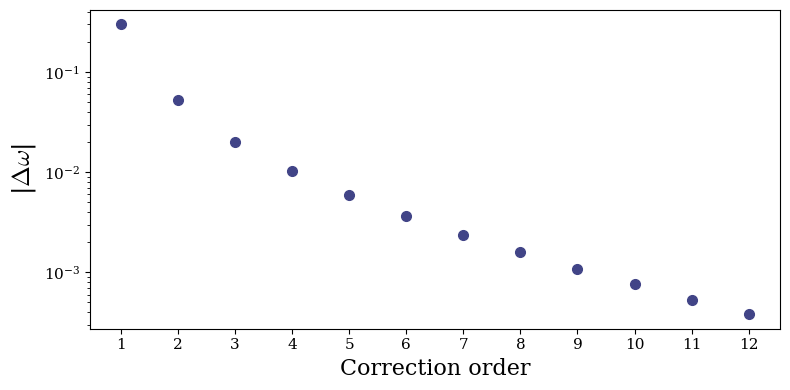

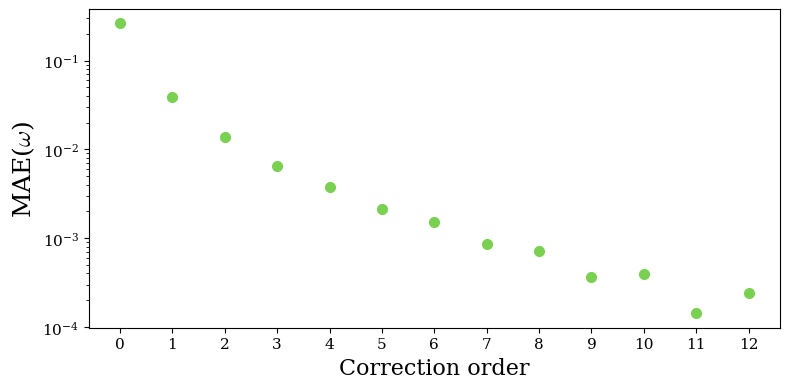

In [345]:
LPM.relative_error(w_final_list[0])
LPM.w_absolute_error(w_final_list[0], w_teor)

In [346]:
w_final = w_final_list[0][-1]
t_eval_lpm, t_eval_standard = LPM.t_eval_lpm(t_eval, w_final)
compare_len = t_eval_standard.shape[0]

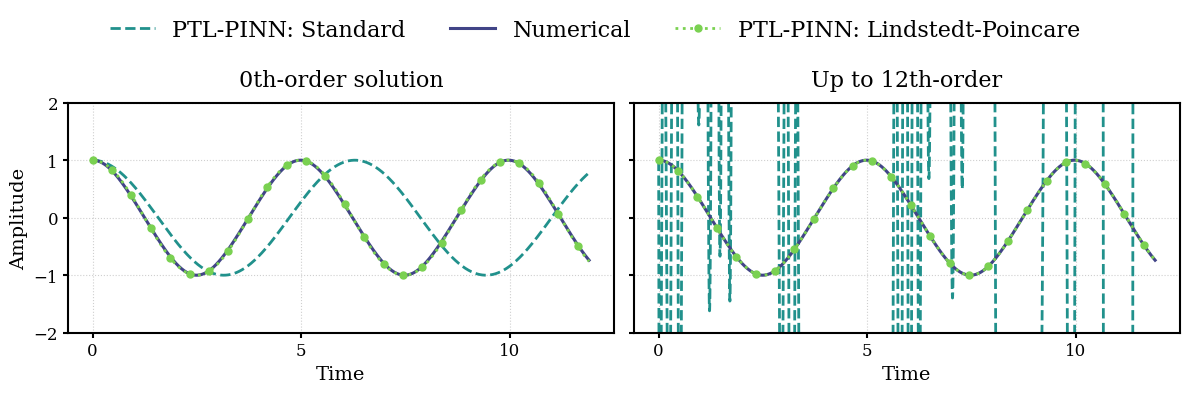

In [347]:
standard.plot_comparison_standard_vs_lpm(t_eval_standard, t_eval_lpm, [i[:compare_len] for i in perturbation_solution_standard], NN_TL_solution_standard[:compare_len], perturbation_solution_LPM, NN_TL_solution_LPM, numerical_undamped_duffing[:, :compare_len], order=p_list[0])

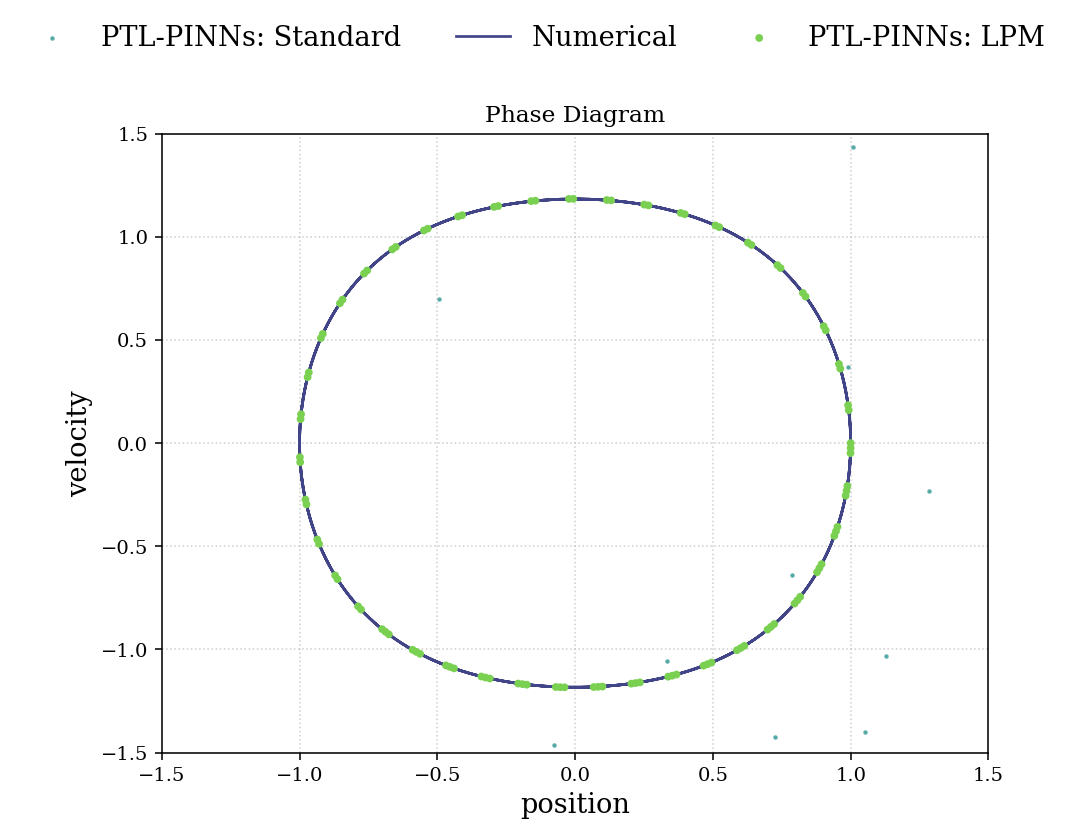

In [348]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_phase_diagrams(
    arr_list, labels=None,
    xlab="position", ylab="velocity", title="Phase Diagram",
    s=8, alpha=0.6, xlim=None, ylim=None,
    lpm_index=None, omega=None, lpm_stride=30
):
    """
    arr_list : list of arrays, each shape (N, 2) or (2, N)
    labels   : list of labels for the legend
    lpm_index: index in arr_list that corresponds to the LPM solution
    omega    : angular frequency for scaling LPM's velocity component
    lpm_stride: plot every lpm_stride-th point for the LPM curve
    """
    fig, ax = plt.subplots(figsize=(7, 6), dpi=140)

    # Custom colors from viridis
    cmap = plt.cm.viridis
    num_color = cmap(0.2)   # deep bluish
    std_color = cmap(0.5)   # medium greenish
    lpm_color = cmap(0.8)   # yellow-green

    if labels is None:
        labels = [f"Array {i+1}" for i in range(len(arr_list))]

    handles_all, labels_all = [], []

    # --- Order: Standard (back) → Numerical → LPM (front) ---
    order = [2, 1, 0]

    for i in order:
        arr = np.asarray(arr_list[i])
        label = labels[i]

        # Ensure shape (N, 2)
        if arr.shape[0] == 2 and arr.shape[1] != 2:
            arr = arr.T

        # Apply frequency scaling to the LPM solution
        if i == lpm_index and omega is not None:
            arr = arr.copy()
            arr[:, 1] *= omega

        mask = np.all(np.isfinite(arr), axis=1)
        x, y = arr[mask, 0], arr[mask, 1]

        if i == 2:  # Standard (back)
            h = ax.scatter(x, y, s=s, alpha=alpha, c=[std_color],
                           marker='.', label=label, zorder=1)
        elif i == 1:  # Numerical
            h, = ax.plot(x, y, color=num_color, linewidth=1.4,
                         label=label, zorder=2)
        elif i == 0:  # LPM (front, sparse points)
            idx = np.arange(0, len(x), max(1, lpm_stride))
            h = ax.scatter(x[idx], y[idx], s=s*2, alpha=1.0, c=[lpm_color],
                           marker='o', edgecolors='none', label=label, zorder=3)

        handles_all.append(h)
        labels_all.append(label)

    ax.set_xlabel(xlab, fontsize=14)
    ax.set_ylabel(ylab, fontsize=14)
    ax.set_title(title)
    ax.grid(True, linestyle=':', alpha=0.6)

    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)

    # Legend on top, same style as your other plot
    fig.legend(handles_all, labels_all,
               loc='upper center', ncol=3, frameon=False, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()


# Example call
plot_multiple_phase_diagrams(
    [NN_TL_solution_LPM, numerical_undamped_duffing, NN_TL_solution_standard],
    labels=["PTL-PINNs: LPM", "Numerical", "PTL-PINNs: Standard"],
    lpm_index=0,
    omega=w_teor,
    lpm_stride=50,
    xlim=(-1.5, 1.5),
    ylim=(-1.5, 1.5)
)

